In [52]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf


##########################      DATA     ######################################

def parse_function(example_proto):
    feature_description = {
        'V0': tf.io.FixedLenFeature([], tf.string),
        'Vt': tf.io.FixedLenFeature([], tf.string),
        'M0': tf.io.FixedLenFeature([], tf.string),
        'Mt': tf.io.FixedLenFeature([], tf.string),
        'res': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    V0 = tf.io.decode_raw(parsed_features['V0'], tf.float32)
    Vt = tf.io.decode_raw(parsed_features['Vt'], tf.float32)
    M0 = tf.io.decode_raw(parsed_features['M0'], tf.float32)
    Mt = tf.io.decode_raw(parsed_features['Mt'], tf.float32)
    res = tf.io.decode_raw(parsed_features['res'], tf.float32)
    V0 = tf.reshape(V0, [128, 128, 16, 1])
    Vt = tf.reshape(Vt, [128, 128, 16, 1])
    M0 = tf.reshape(M0, [128, 128, 16, 1])
    Mt = tf.reshape(Mt, [128, 128, 16, 1])
    res = tf.reshape(res, [128, 128, 16, 1])

    x = {'input_1': V0, 'input_2': Vt}
    y = tf.stack([V0, Vt, M0, Mt, res], axis=0)

    return x,y

def load_tfrecord(filename):
    raw_dataset = tf.data.TFRecordDataset(filename)
    parsed_dataset = raw_dataset.map(parse_function)
    return parsed_dataset

##########################      Data Aug     ######################################

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_batch = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=None),
      tf.keras.layers.experimental.preprocessing.RandomRotation(1, seed=None),
      tf.keras.layers.experimental.preprocessing.RandomContrast(0.5, seed=None)
    ])

  def call(self, inputs, labels):
    ## unstack 2 batched inputs shape (batch, 128, 128, 16, 1) each in axis -2, and stack them back after augmentation
    ## unstack batched labels shape (batch, 5, 128, 128, 16, 1) each in axis -2 and -5, and stack them back after augmentation
    ## concat after unstacking to generate one big batch
    nz = labels.shape[-2]
      
    augmented = self.augment_batch(tf.concat(
      [tf.concat(tf.unstack(inputs['input_1'], axis=-2), axis=-1),
      tf.concat(tf.unstack(inputs['input_2'], axis=-2), axis=-1),
      tf.concat(tf.unstack(labels[:,0], axis=-2), axis=-1),
      tf.concat(tf.unstack(labels[:,1], axis=-2), axis=-1),
      tf.concat(tf.unstack(labels[:,2], axis=-2), axis=-1),
      tf.concat(tf.unstack(labels[:,3], axis=-2), axis=-1),
      tf.concat(tf.unstack(labels[:,4], axis=-2), axis=-1)],
      axis=-1
    ))

    inputs['input_1'] = tf.expand_dims(tf.stack(tf.unstack(augmented[...,:nz], axis=-1), axis=-1), axis=-1)
    inputs['input_2'] = tf.expand_dims(tf.stack(tf.unstack(augmented[...,nz:2*nz], axis=-1), axis=-1), axis=-1)

    labels = tf.stack([
      tf.expand_dims(tf.stack(tf.unstack(augmented[...,2*nz:3*nz], axis=-1), axis=-1), axis=-1),
      tf.expand_dims(tf.stack(tf.unstack(augmented[...,3*nz:4*nz], axis=-1), axis=-1), axis=-1),
      tf.expand_dims(tf.stack(tf.unstack(augmented[...,4*nz:5*nz], axis=-1), axis=-1), axis=-1),
      tf.expand_dims(tf.stack(tf.unstack(augmented[...,5*nz:6*nz], axis=-1), axis=-1), axis=-1),
      tf.expand_dims(tf.stack(tf.unstack(augmented[...,6*nz:7*nz], axis=-1), axis=-1), axis=-1),
    ], axis=1)
                        
    return inputs, labels



dataset = load_tfrecord('data/training/trainingEDES.tfrecord')

# shuffle and batch
dataset = (
    dataset
    .cache()
    #.shuffle(50)
    .batch(1)
    #.map(Augment())
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

dataset = dataset.filter(lambda x,y: tf.reduce_any(tf.not_equal(x['input_1'], x['input_2']))).take(1)


2022-09-16 18:19:29.142251: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


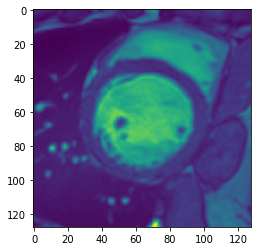

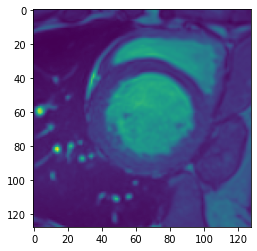

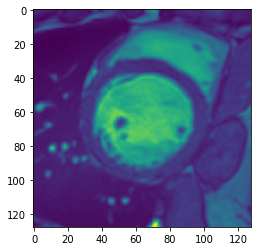

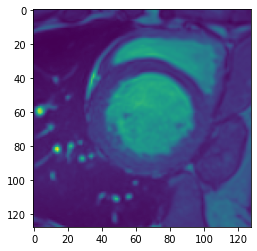

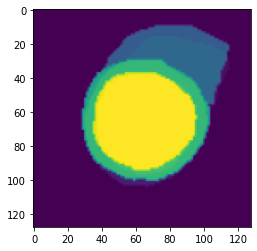

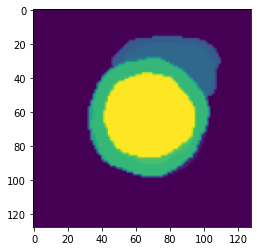

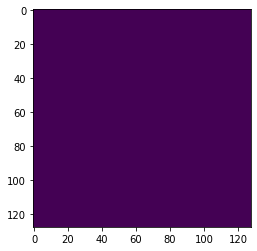

<Figure size 432x288 with 0 Axes>

In [53]:
import matplotlib.pyplot as plt

dataset = dataset.as_numpy_iterator()

for i,(x,y) in enumerate(dataset):
    plt.figure()
    plt.imshow(x['input_1'][0,...,5,0])
    plt.figure()
    plt.imshow(x['input_2'][0,...,5,0])
    plt.figure()
    plt.imshow(y[0,0,...,5,0])
    plt.figure()
    plt.imshow(y[0,1,...,5,0])
    plt.figure()
    plt.imshow(y[0,2,...,5,0])
    plt.figure()
    plt.imshow(y[0,3,...,5,0])
    plt.figure()
    plt.imshow(y[0,4,...,5,0])
    plt.figure()